# Energy overhead study
In this notebook, we study the additional energy cost of each solution. We proceed by comparing the energy consumed by executions with and without tools.

## Import necessary libraries

In [1]:
%load_ext autoreload
%autoreload 2

from visualize import *
import seaborn as sns
import matplotlib.pyplot as plt

## Load experiment results

In [2]:
experiments_path = [
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-17_43_02',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-18_13_34',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-18_44_13',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-19_14_33',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-19_45_01',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-20_15_24',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-20_46_11',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-21_17_22',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-21_48_15',
    '3-solutions-compare-gemini-1.lyon.grid5000.fr-2022-09-28-22_18_42'
]

experiments_no_solution_path = [
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-22_28_49',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-22_38_27',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-22_47_56',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-22_57_28',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-23_07_17',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-23_16_57',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-23_26_44',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-23_36_31',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-23_46_05',
    'no-solution-gemini-1.lyon.grid5000.fr-2022-09-28-23_55_46'
]

experiments = []
for experiment_path in experiments_path:
    experiments.append(parse_experiment("../results/%s" % experiment_path))

experiments_no_solution = []
for experiment_path in experiments_no_solution_path:
    experiments_no_solution.append(parse_experiment("../results/%s" % experiment_path))

# Additional processing is required for Scaphandre dataframes
# Scaphandre by component result dataframes will be joined into a single dataframe
process_scaphandre_dataframes(experiments)

## Calculate energy overhead 

In [3]:
# Convert 10 experiments to by benchmark set of experiments for every solution
benchmarks_powerapi = convert_exp_into_benchmark_dataframes(experiments, 'PowerAPI' ,'powerapi', 0)
benchmarks_scaphandre = convert_exp_into_benchmark_dataframes(experiments, 'Scaphandre' ,'scaphandre', 0)
benchmarks_no_solution = convert_exp_into_benchmark_dataframes(experiments_no_solution, 'Kwollect', 'kwollect', 0)


# Calculate total consumption for each dataframe
result_df = pd.DataFrame(columns=['benchmark', 'tool', 'value'])
result_df = calculate_total_consumption(result_df, benchmarks_no_solution, 'no_tool')
result_df = calculate_total_consumption(result_df, benchmarks_powerapi, 'powerapi')
result_df = calculate_total_consumption(result_df, benchmarks_scaphandre, 'scaphandre')

# Associate a no_tool measure that is the median value of all no tool measures for a specific benchmark
result_df['no_tool_measure'] = result_df.apply(
        lambda row: result_df[(result_df['benchmark'] == row['benchmark']) & (result_df['tool'] == 'no_tool')]['value'].median(), 
        axis=1)

# Calculate overhead in percentage
result_df['overhead'] = (1 - result_df['no_tool_measure']/result_df['value']) * 100

## Show energy overhead statistics

### Overhead by tool

In [4]:
result_df.groupby(['tool'])[['overhead']].agg(['mean','std'])

overhead          
                mean       std
tool                          
no_tool     0.532120  3.450072
powerapi   -1.307126  4.265919
scaphandre  2.563689  4.020659

### Overhead by benchmark and by tool

In [5]:
result_df.groupby(['tool', 'benchmark'])[['overhead']].agg(['mean','std'])

overhead          
                                   mean       std
tool       benchmark                             
no_tool    EP D NAS Benchmark  0.597147  0.983380
           LU C NAS Benchmark  0.631794  2.257293
           MG D NAS Benchmark  0.367420  5.678539
powerapi   EP D NAS Benchmark  0.059573  0.063560
           LU C NAS Benchmark  0.348087  2.030802
           MG D NAS Benchmark -4.329038  6.264490
scaphandre EP D NAS Benchmark  0.852285  1.030650
           LU C NAS Benchmark  5.527431  3.024879
           MG D NAS Benchmark  1.311350  5.207748

## Plot energy overhead for EP benchmark

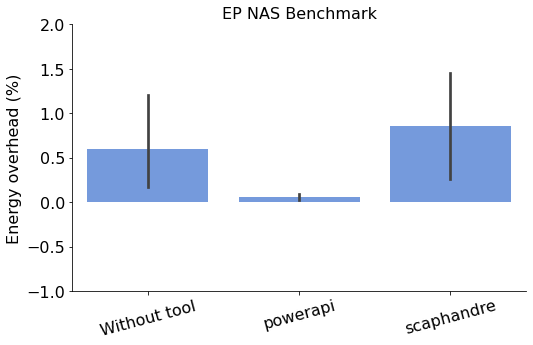

In [6]:
# Change benchmark names in plots
result_df.loc[result_df['benchmark'] == 'EP D NAS Benchmark','benchmark'] = 'EP NAS Benchmark'
result_df.loc[result_df['benchmark'] == 'LU C NAS Benchmark','benchmark'] = 'LU NAS Benchmark'
result_df.loc[result_df['benchmark'] == 'MG D NAS Benchmark','benchmark'] = 'MG NAS Benchmark'
result_df.loc[result_df['tool'] == 'no_tool','tool'] = 'Without tool'

plt.rcParams.update({'font.size': 16})

resulf_df_plot = result_df[result_df['benchmark'] == 'EP NAS Benchmark']

ax = sns.catplot(x="tool", y="overhead",
                 col="benchmark",
                 data=resulf_df_plot, 
                 kind="bar",
                 height=5,
                 aspect=1.5,
                 color="cornflowerblue")

ax.set_xticklabels(rotation=15)
ax.set_xlabels("")
ax.set_ylabels("Energy overhead (%)", fontsize="16")
ax.set(ylim=(-1, 2))
ax.set_titles(template='{col_name}')

ax.savefig('../figures/energy_overhead_no_energy_scope.pdf')
ax.savefig('../figures/energy_overhead_no_energy_scope.png')